In [1]:
# Core
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# Request the description of each col
from projeto1bi.utils import dic_cols

# Viz (quick EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: data prep, CV, metrics, baseline models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Quality of life
import warnings; warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)


In [29]:
from pathlib import Path

folder_dir = "data"

base_path = Path.cwd().parent / folder_dir
dim_teachers =  pd.read_csv(base_path / "dim_teachers.csv")
fct_interaction = pd.read_csv(base_path / "fct_teachers_contents_interactions.csv")
fct_entries = pd.read_csv(base_path / "fct_teachers_entries.csv")
dictionary = pd.read_csv(base_path / "aprendizap_dictionary.csv")

In [30]:
fct_entries["data_inicio"] = pd.to_datetime(fct_entries["data_inicio"], errors="coerce")
fct_entries["data_fim"] = pd.to_datetime(fct_entries["data_fim"], errors="coerce")

In [31]:
fct_entries["tempo_sessao"] = fct_entries["data_fim"] - fct_entries["data_inicio"]

fct_entries["tempo_sessao"] = fct_entries["tempo_sessao"].dt.total_seconds() / 60

In [32]:
fct_entries.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767


In [33]:
fct_entries_agg =(
    fct_entries
    .groupby("unique_id")
    .agg(
        sessao_medio = ("tempo_sessao", "mean"),
        sessao_total = ("tempo_sessao", "sum")
    )
    .reset_index()
)

In [34]:
fct_dim_agg = fct_entries_agg.merge(dim_teachers, on = "unique_id", how="left")

In [35]:
# Célula corrigida para unificar as tabelas e analisar os dados faltantes

# --- PASSO DE CORREÇÃO: Alinhar os Tipos de Dados ---
# Documentação: Garantimos que a coluna 'data_inicio' em AMBAS as tabelas seja do tipo datetime.
# Esta é a correção para o erro 'ValueError'.
print("Convertendo 'data_inicio' em fct_interaction para datetime...")
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])
print("Conversão concluída!")
print("-" * 50)


# --- PASSO 1: UNIFICAR AS TABELAS ---
print("Iniciando a unificação das tabelas com a chave correta...")

# Unimos usando a chave composta ['unique_id', 'data_inicio']. Agora os tipos de dados são compatíveis.
df_unificado = pd.merge(
    fct_interaction,
    fct_entries,
    on=['unique_id', 'data_inicio'],
    how='left',
    suffixes=('_interacao', '_sessao')
)

# Unimos com os dados dos professores.
df_unificado = pd.merge(
    df_unificado,
    dim_teachers,
    on='unique_id',
    how='left'
)

print(f"Unificação concluída! O dataframe 'df_unificado' foi criado com {df_unificado.shape[0]} linhas e {df_unificado.shape[1]} colunas.")
print("-" * 50)


# --- PASSO 2: ANÁLISE DE DADOS FALTANTES (NAs) ---
print("Analisando dados faltantes no dataframe 'df_unificado'...")

# Calcula a contagem e a porcentagem de NAs
dados_faltantes_cont = df_unificado.isnull().sum()
dados_faltantes_perc = (df_unificado.isnull().sum() / len(df_unificado)) * 100

# Cria um dataframe para exibir os resultados
df_dados_faltantes = pd.DataFrame({
    'Contagem de NAs': dados_faltantes_cont,
    'Porcentagem de NAs (%)': dados_faltantes_perc
})

# Filtra para mostrar apenas as colunas com dados faltantes
df_dados_faltantes = df_dados_faltantes[df_dados_faltantes['Contagem de NAs'] > 0].sort_values(
    by='Porcentagem de NAs (%)', ascending=False
)

# Exibe o resultado usando print() para máxima compatibilidade
print("\nAnálise de Dados Faltantes na Base Unificada:")
print(df_dados_faltantes)

Convertendo 'data_inicio' em fct_interaction para datetime...
Conversão concluída!
--------------------------------------------------
Iniciando a unificação das tabelas com a chave correta...
Unificação concluída! O dataframe 'df_unificado' foi criado com 3689153 linhas e 24 colunas.
--------------------------------------------------
Analisando dados faltantes no dataframe 'df_unificado'...

Análise de Dados Faltantes na Base Unificada:
                              Contagem de NAs  Porcentagem de NAs (%)
content_type                          3315760               89.878625
user_type_sessao                      3189245               86.449247
data_fim                              3189245               86.449247
tempo_sessao                          3189245               86.449247
login_google                          2666031               72.266751
visualizou_metodologia_ativa          2653523               71.927703
selectedsubjectsem                    2386024               64.676743

In [36]:
# Célula para verificar os nomes das colunas

print("Colunas da tabela 'fct_interaction':")
print(list(fct_interaction.columns))

print("\n" + "="*50 + "\n")

print("Colunas da tabela 'fct_entries':")
print(list(fct_entries.columns))

Colunas da tabela 'fct_interaction':
['unique_id', 'user_type', 'user_agent_device_type', 'data_inicio', 'event_type', 'content_type', 'id_aula', 'utm_source']


Colunas da tabela 'fct_entries':
['unique_id', 'user_type', 'data_inicio', 'data_fim', 'tempo_sessao']


In [37]:
# Célula para agregar os dados da tabela fct_entries

# Documentação:
# O objetivo é transformar a tabela de sessões (onde cada linha é uma entrada)
# em uma tabela onde cada linha é um professor ('unique_id') com suas métricas de sessão resumidas.
# Usaremos groupby() para agrupar por professor e agg() para calcular várias métricas de uma só vez.

# Primeiro, vamos garantir que o tempo_sessao nulo seja 0, como fizemos antes.
fct_entries['tempo_sessao'].fillna(0, inplace=True)

df_entries_agg = fct_entries.groupby('unique_id').agg(
    total_sessoes=('unique_id', 'count'),      # Conta o número de sessoes
    tempo_total_sessao=('tempo_sessao', 'sum'), # Soma o tempo de todas as sessoes
    tempo_medio_sessao=('tempo_sessao', 'mean') # Calcula a média do tempo de sessão
).reset_index()

print("Tabela de sessões agregada por professor:")
print(df_entries_agg.head())

print(f"\nCriamos um resumo para {df_entries_agg.shape[0]} professores únicos.")

Tabela de sessões agregada por professor:
                              unique_id  total_sessoes  tempo_total_sessao  \
0  000005b8-e073-4b3d-858a-cc2a51f6ae76              1            0.254767   
1  00000ac4-2412-4cba-a7fd-000271cd2459              1            0.003600   
2  00001d14-1398-4e03-b1b7-561cb2d2423a              2            0.019233   
3  00003562-eb2f-481b-a082-f30dc8cb3d4a              2            3.380883   
4  00003a13-91d1-46bf-934d-72f17f4c5a12              1            0.326367   

   tempo_medio_sessao  
0            0.254767  
1            0.003600  
2            0.009617  
3            1.690442  
4            0.326367  

Criamos um resumo para 1317999 professores únicos.


In [38]:
# Célula para agregar os dados da tabela fct_interaction

# Documentação:
# O objetivo aqui é criar um perfil de uso para cada professor.
# Vamos agrupar por professor ('unique_id') e por tipo de evento ('event_type').
# Em seguida, usamos .unstack() para transformar os tipos de evento em colunas,
# nos dando a contagem de cada ação por professor.

# Primeiro, removemos interações onde o event_type é nulo, pois não seriam úteis.
fct_interaction_clean = fct_interaction.dropna(subset=['event_type'])

df_interaction_agg = fct_interaction_clean.groupby(['unique_id', 'event_type']).size().unstack(fill_value=0)

# Para facilitar a leitura, vamos renomear as colunas adicionando um prefixo.
df_interaction_agg = df_interaction_agg.add_prefix('evento_')

# Agora, vamos criar uma coluna com o total de interações somando as contagens de cada evento.
df_interaction_agg['total_interacoes'] = df_interaction_agg.sum(axis=1)


print("Tabela de interações agregada por professor:")
print(df_interaction_agg.head())

print(f"\nCriamos um perfil de interação para {df_interaction_agg.shape[0]} professores únicos.")

Tabela de interações agregada por professor:
event_type                            evento_acesso_aba_conquistas  \
unique_id                                                            
000005b8-e073-4b3d-858a-cc2a51f6ae76                             0   
00000ac4-2412-4cba-a7fd-000271cd2459                             0   
00001d14-1398-4e03-b1b7-561cb2d2423a                             0   
00003562-eb2f-481b-a082-f30dc8cb3d4a                             0   
00003a13-91d1-46bf-934d-72f17f4c5a12                             0   

event_type                            evento_acesso_comunidade  \
unique_id                                                        
000005b8-e073-4b3d-858a-cc2a51f6ae76                         0   
00000ac4-2412-4cba-a7fd-000271cd2459                         0   
00001d14-1398-4e03-b1b7-561cb2d2423a                         0   
00003562-eb2f-481b-a082-f30dc8cb3d4a                         0   
00003a13-91d1-46bf-934d-72f17f4c5a12                         0   

e

In [39]:
df_interaction_agg.head()

event_type,evento_acesso_aba_conquistas,evento_acesso_comunidade,evento_botao_baixar_conquista_completada,evento_botao_baixar_conquista_modal,evento_botao_compartilhar_conquista_completada,evento_botao_compartilhar_conquista_modal,evento_botao_criar_plano_aula,evento_botao_criar_plano_sem_aula,evento_click_link_missao_aulas,evento_click_link_missao_blog,...,evento_prova_salva,evento_rascunho_plano_aula,evento_rascunho_prova,evento_visualizacao_aula,evento_visualizacao_avaliacao,evento_visualizacao_conteudo_ia,evento_visualizacao_metodologia_ativa,evento_visualizacao_plano_aula,evento_visualizacao_prova,total_interacoes
unique_id,,,,,,,,,,,,,,,,,,,,,
000005b8-e073-4b3d-858a-cc2a51f6ae76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
00000ac4-2412-4cba-a7fd-000271cd2459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
00001d14-1398-4e03-b1b7-561cb2d2423a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
00003562-eb2f-481b-a082-f30dc8cb3d4a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
00003a13-91d1-46bf-934d-72f17f4c5a12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [45]:
# Célula para a unificação final de todas as tabelas agregadas

# Documentação:
# Passo 1: Começamos com a tabela de professores como nossa base.
# Em seguida, adicionamos as métricas de sessão agregadas ('df_entries_agg').
df_professores = pd.merge(
    dim_teachers,
    df_entries_agg,
    on='unique_id',
    how='left'
)

# Passo 2: Adicionamos as métricas de interação agregadas ('df_interaction_agg') à tabela resultante.
df_professores = pd.merge(
    df_professores,
    df_interaction_agg,
    on='unique_id',
    how='left'
)

# Documentação:
# Passo 3: Após os 'left merges', professores sem atividade terão valores NaN (nulos) nas colunas agregadas.
# Vamos preencher todos esses nulos com 0, pois representa ausência de atividade.
colunas_para_preencher = [
    'total_sessoes', 'tempo_total_sessao', 'tempo_medio_sessao', 'total_interacoes',
    'evento_create', 'evento_delete', 'evento_download', 'evento_share', 'evento_view'
]

# Vamos garantir que estamos preenchendo apenas as colunas que realmente existem no dataframe
colunas_existentes = [col for col in colunas_para_preencher if col in df_professores.columns]
for coluna in colunas_existentes:
    df_professores[coluna].fillna(0, inplace=True)


print("Unificação Final Concluída!")
print("Amostra do dataframe final de professores:")
# Usando print() para garantir compatibilidade
print(df_professores.head())

print("\nVerificando a estrutura e os tipos de dados do dataframe final:")
df_professores.info()

Unificação Final Concluída!
Amostra do dataframe final de professores:
                              unique_id profid        utm_origin  \
0  f1dbcf6e-700a-4a9b-aa78-4c53270f929e    NaN      Landing Page   
1  0da949a1-b3be-4e4e-8303-b9319d0475ff    NaN      Landing Page   
2  a8115c6f-28d9-4231-aae9-f263f08b1919    NaN      Landing Page   
3  a67cc2f5-95b5-4cb5-9a5b-3766de9be130    NaN      Landing Page   
4  99bcf296-626c-488e-901a-5cf6a4525fcf    NaN  Não identificado   

    tela_origem estado  total_alunos  login_google currentstage  \
0  Tela inicial     MG          30.0           NaN       fundii   
1  Tela inicial     PE          40.0           NaN           em   
2  Tela inicial     MT           0.0           NaN           em   
3  Tela inicial     MS          30.0           NaN       fundii   
4  Tela inicial     SP           0.0           NaN       fundii   

  currentsubject selectedstages  ... evento_prova_salva  \
0              1       [fundii]  ...                0.0   

In [ ]:
df_professores.info

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,...,evento_prova_salva,evento_rascunho_plano_aula,evento_rascunho_prova,evento_visualizacao_aula,evento_visualizacao_avaliacao,evento_visualizacao_conteudo_ia,evento_visualizacao_metodologia_ativa,evento_visualizacao_plano_aula,evento_visualizacao_prova,total_interacoes
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,NaN,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,NaN,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2,a8115c6f-28d9-4231-aae9-f263f08b1919,NaN,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]",...,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,27.0
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,NaN,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
4,99bcf296-626c-488e-901a-5cf6a4525fcf,NaN,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0


In [48]:
from sklearn.preprocessing import StandardScaler

# --- PASSO 4: SELEÇÃO DINÂMICA DAS FEATURES ---
# Documentação:
# CORREÇÃO: Em vez de uma lista manual, vamos construir a lista de features de forma inteligente.

# 1. Definimos as features base que conhecemos
features_base = [
    'total_sessoes',
    'tempo_total_sessao',
    'tempo_medio_sessao',
    'total_interacoes',
    'total_alunos' # Adicionando a feature que incluímos na análise de correlação
]

# 2. Encontramos dinamicamente TODAS as colunas que começam com 'evento_'
features_de_evento = [col for col in df_professores.columns if col.startswith('evento_')]

# 3. Juntamos as duas listas para ter nossa lista final e completa de features
features_numericas_completas = features_base + features_de_evento

# Criamos um novo dataframe apenas com essas features
# (Aqui não precisamos mais da verificação 'features_existentes', pois já construímos a lista a partir das colunas que existem)
df_features = df_professores[features_numericas_completas]

print("--- Features Selecionadas para o Modelo (Versão Completa) ---")
print(f"Total de features: {len(df_features.columns)}")
print(df_features.columns.tolist())


# --- PASSO 5: ESCALONAMENTO DOS DADOS ---
# Documentação:
# O restante do processo continua o mesmo, mas agora aplicado ao conjunto completo de features.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

# Para facilitar a visualização, convertemos de volta para um DataFrame.
df_features_scaled = pd.DataFrame(features_scaled, columns=features_numericas_completas)

print("\n--- Amostra dos dados após o escalonamento (com todas as features) ---")
print(df_features_scaled.head())

--- Features Selecionadas para o Modelo (Versão Completa) ---
Total de features: 41
['total_sessoes', 'tempo_total_sessao', 'tempo_medio_sessao', 'total_interacoes', 'total_alunos', 'evento_acesso_aba_conquistas', 'evento_acesso_comunidade', 'evento_botao_baixar_conquista_completada', 'evento_botao_baixar_conquista_modal', 'evento_botao_compartilhar_conquista_completada', 'evento_botao_compartilhar_conquista_modal', 'evento_botao_criar_plano_aula', 'evento_botao_criar_plano_sem_aula', 'evento_click_link_missao_aulas', 'evento_click_link_missao_blog', 'evento_click_link_missao_comunidade', 'evento_click_link_missao_mari', 'evento_click_link_missao_plano_de_aula', 'evento_click_link_missao_relatorio_turma', 'evento_click_selo_conquista', 'evento_click_subaba_concluidas', 'evento_click_subaba_disponiveis', 'evento_compartilhamento_direto', 'evento_criacao_anotacao_relatorio', 'evento_criacao_plano_aula', 'evento_criacao_turma_relatorio', 'evento_download_aula', 'evento_download_avaliacao'

Calculando a matriz de correlação...

--- Top 20 Pares de Features Mais Correlacionadas ---
total_sessoes                       tempo_total_sessao                    0.977887
tempo_total_sessao                  total_sessoes                         0.977887
                                    evento_visualizacao_avaliacao         0.951239
evento_visualizacao_avaliacao       tempo_total_sessao                    0.951239
tempo_total_sessao                  evento_compartilhamento_direto        0.951140
evento_compartilhamento_direto      tempo_total_sessao                    0.951140
evento_visualizacao_avaliacao       evento_compartilhamento_direto        0.926346
evento_compartilhamento_direto      evento_visualizacao_avaliacao         0.926346
                                    total_sessoes                         0.922613
total_sessoes                       evento_compartilhamento_direto        0.922613
                                    evento_visualizacao_avaliacao         0.91

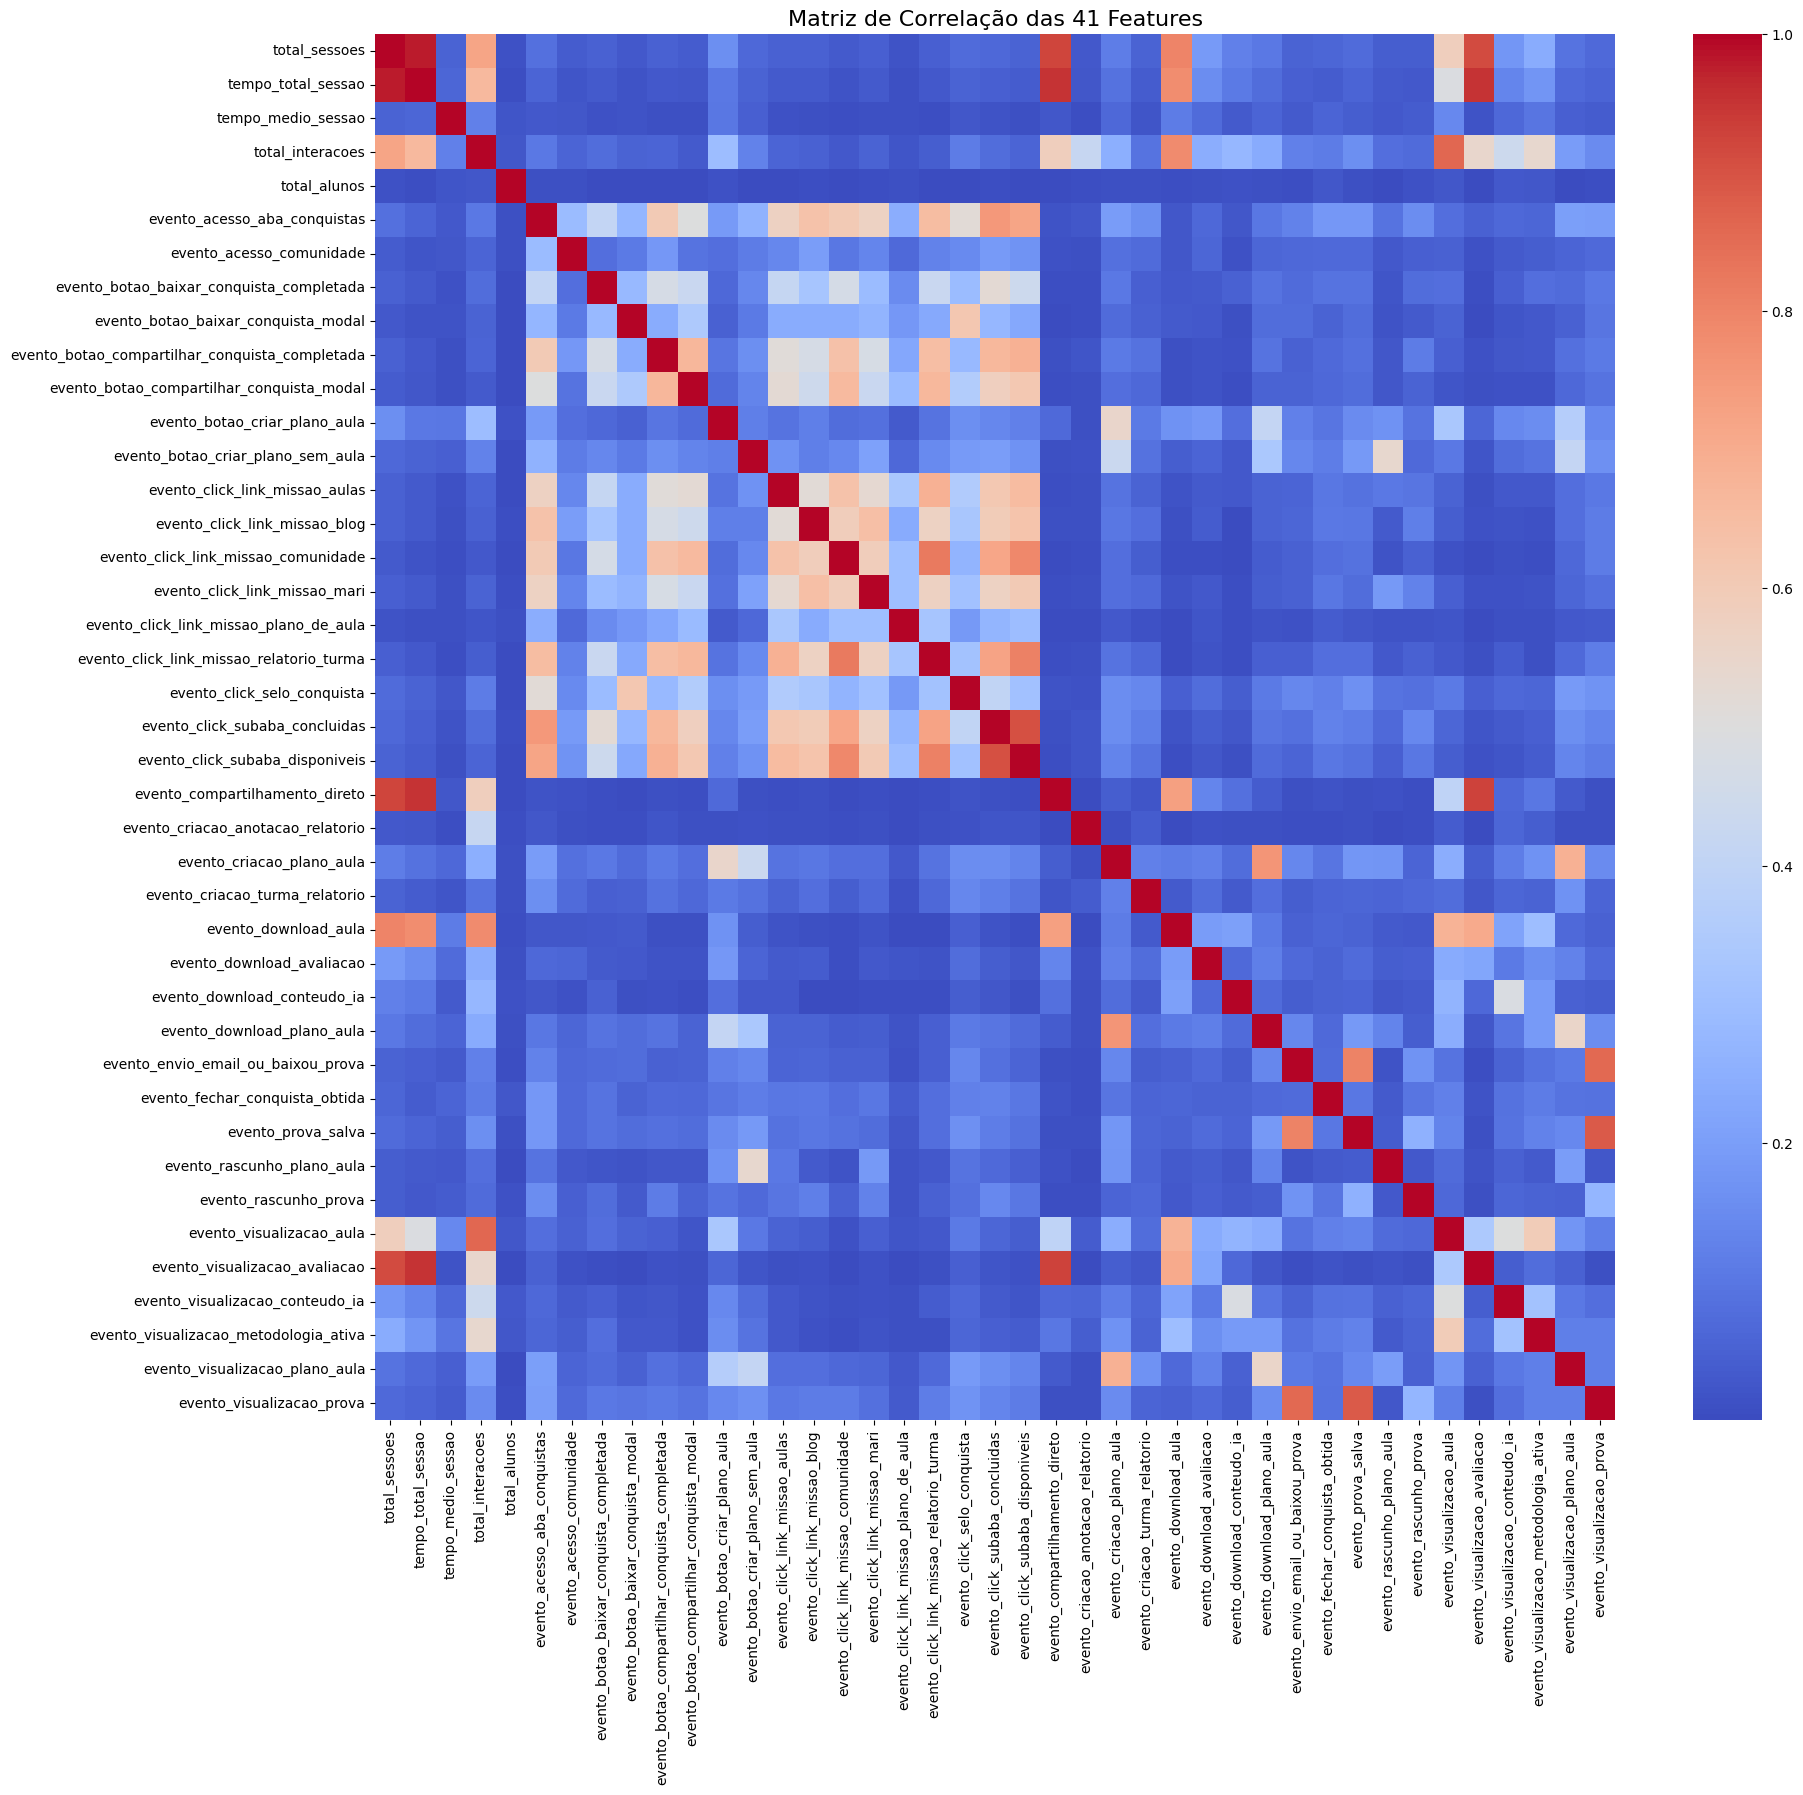

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- PASSO 1: ANÁLISE PROGRAMÁTICA DAS CORRELAÇÕES ---
# Documentação:
# Calculamos a matriz de correlação e depois a transformamos em uma lista de pares
# para podermos identificar e ordenar as correlações mais fortes de forma fácil.

print("Calculando a matriz de correlação...")
# Usamos o df_features que tem os dados originais (não escalonados) e completos
correlation_matrix = df_features.corr().abs()

# "Desempilhamos" a matriz para criar uma lista de pares e ordená-la
sol = correlation_matrix.unstack()
so = sol.sort_values(kind="quicksort", ascending=False)

# Removemos as correlações de uma variável com ela mesma (que são sempre 1)
# e mostramos os 20 pares mais correlacionados
print("\n--- Top 20 Pares de Features Mais Correlacionadas ---")
# Filtramos para remover a auto-correlação (onde o valor é 1.0)
pares_correlacionados = so[so < 1.0]
print(pares_correlacionados.head(20))


# --- PASSO 2: ANÁLISE VISUAL (HEATMAP) ---
# Documentação:
# Geramos o heatmap sem as anotações numéricas para ter uma visão macro
# dos grupos de variáveis que são correlacionadas entre si.

print("\nGerando o heatmap para visualização geral...")
plt.figure(figsize=(20, 18)) # Aumentamos o tamanho para caber as 41 features
sns.heatmap(
    correlation_matrix,
    annot=False, # 'False' para não poluir o gráfico com números
    cmap='coolwarm'
)
plt.title("Matriz de Correlação das 41 Features", fontsize=16)
plt.show()

In [50]:
# Célula de Verificação
print("--- Verificando o estado do dataframe 'df_professores' ---")
print(f"O dataframe tem {df_professores.shape[0]} linhas e {df_professores.shape[1]} colunas.")
print("\nAs 5 últimas colunas são:")
print(list(df_professores.columns[-5:]))

--- Verificando o estado do dataframe 'df_professores' ---
O dataframe tem 1316095 linhas e 54 colunas.

As 5 últimas colunas são:
['evento_visualizacao_conteudo_ia', 'evento_visualizacao_metodologia_ativa', 'evento_visualizacao_plano_aula', 'evento_visualizacao_prova', 'total_interacoes']


In [51]:
# Documentação:
# Iniciamos nosso novo pipeline de modelagem com os dois passos mais importantes:
# 1. Selecionar o conjunto de features curado que decidimos na etapa anterior.
# 2. Identificar e remover os outliers (superusuários) para não enviesar o modelo.

# --- 1. SELEÇÃO DO NOVO CONJUNTO DE FEATURES ---

# Esta é a lista de features que selecionamos, cada uma representando uma dimensão diferente do comportamento.
features_selecionadas = [
    'total_interacoes',       # Volume de Atividade
    'tempo_medio_sessao',     # Qualidade do Engajamento
    'total_alunos',           # Contexto do Professor
    'evento_criacao_plano_aula', # Ação de Alto Valor: Planejamento
    'evento_download_plano_aula',# Ação de Alto Valor: Uso de Conteúdo
    'evento_visualizacao_conteudo_ia' # Adoção de Features Específicas (IA)
]

# Garantimos que usamos apenas colunas que realmente existem
features_existentes = [col for col in features_selecionadas if col in df_professores.columns]

# Criamos um dataframe específico para a modelagem
df_modelo = df_professores[features_existentes]
print(f"Novo conjunto de features selecionado com {len(df_modelo.columns)} colunas.")


# --- 2. REMOÇÃO DE OUTLIERS ---

# Definimos um outlier como um usuário cujo 'total_interacoes' está acima do percentil 99.9.
# Esta é uma forma estatística de remover os usuários com atividade mais extrema.
limite_outlier = df_modelo['total_interacoes'].quantile(0.999)
print(f"\nO limite para ser considerado um outlier é de {limite_outlier:.2f} interações totais.")

# Filtramos o dataframe para manter apenas os usuários que NÃO são outliers
df_modelo_sem_outliers = df_modelo[df_modelo['total_interacoes'] <= limite_outlier]

# É importante também criar uma versão do df_professores sem os outliers, para uso futuro
df_professores_sem_outliers = df_professores[df_professores['total_interacoes'] <= limite_outlier]


print(f"{len(df_modelo) - len(df_modelo_sem_outliers)} outliers (superusuários) foram removidos para a modelagem.")
print(f"O novo dataframe para modelagem tem {df_modelo_sem_outliers.shape[0]} linhas.")

print("\nAmostra do dataframe final para modelagem:")
print(df_modelo_sem_outliers.head())

Novo conjunto de features selecionado com 6 colunas.

O limite para ser considerado um outlier é de 206.00 interações totais.
1315 outliers (superusuários) foram removidos para a modelagem.
O novo dataframe para modelagem tem 1314780 linhas.

Amostra do dataframe final para modelagem:
   total_interacoes  tempo_medio_sessao  total_alunos  \
0               1.0            2.247167          30.0   
1               2.0            1.371333          40.0   
2              27.0            6.534894           0.0   
3               2.0            2.989183          30.0   
4               4.0            4.288583           0.0   

   evento_criacao_plano_aula  evento_download_plano_aula  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   evento_

In [54]:
from sklearn.preprocessing import StandardScaler

# --- PASSO DE CORREÇÃO: VERIFICAR E REMOVER ÚLTIMOS VALORES NULOS ---
# Documentação:
# O erro indicou a presença de NaNs. Vamos verificar quais colunas ainda os possuem.
print("Verificando a presença de valores nulos (NaN) antes do escalonamento:")
print(df_modelo_sem_outliers.isnull().sum())

# A CORREÇÃO: Preenchemos quaisquer NaNs restantes com 0.
# Isso garante que o dataframe esteja 100% completo para o modelo.
df_modelo_sem_outliers.fillna(0, inplace=True)
print("\nValores nulos preenchidos com 0. Verificação final:")
print(df_modelo_sem_outliers.isnull().sum())
print("-" * 50)


# --- EXECUÇÃO DO ESCALONAMENTO ---
# Agora, com o dataframe garantidamente limpo, o escalonamento vai funcionar.
print("\nIniciando o escalonamento do conjunto de features final...")
scaler_novo = StandardScaler()
features_scaled_novo = scaler_novo.fit_transform(df_modelo_sem_outliers)

df_modelo_scaled = pd.DataFrame(features_scaled_novo, columns=df_modelo_sem_outliers.columns)

print("Escalonamento concluído com sucesso!")
print("\nAmostra dos dados escalonados (versão final):")
print(df_modelo_scaled.head())

Verificando a presença de valores nulos (NaN) antes do escalonamento:
total_interacoes                         0
tempo_medio_sessao                       0
total_alunos                       1178268
evento_criacao_plano_aula           278957
evento_download_plano_aula          278957
evento_visualizacao_conteudo_ia     278957
dtype: int64

Valores nulos preenchidos com 0. Verificação final:
total_interacoes                   0
tempo_medio_sessao                 0
total_alunos                       0
evento_criacao_plano_aula          0
evento_download_plano_aula         0
evento_visualizacao_conteudo_ia    0
dtype: int64
--------------------------------------------------

Iniciando o escalonamento do conjunto de features final...
Escalonamento concluído com sucesso!

Amostra dos dados escalonados (versão final):
   total_interacoes  tempo_medio_sessao  total_alunos  \
0         -0.147924            0.401861      1.082753   
1         -0.025654            0.124173      1.499123   
2    

In [57]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Documentação:
# Para encontrar um bom 'eps' para o DBSCAN, uma técnica comum é calcular a distância
# de cada ponto para seus vizinhos mais próximos e procurar por um "cotovelo" no gráfico dessas distâncias.

# min_samples é o outro parâmetro do DBSCAN. Uma boa regra geral é usar 2 * (número de features).
# No nosso caso, 2 * 6 = 12. Vamos usar 15 para um pouco mais de robustez.
min_samples = 15

# Calculamos as distâncias
print("Calculando as distâncias dos vizinhos mais próximos...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_modelo_scaled)
distances, indices = neighbors_fit.kneighbors(df_modelo_scaled)

# Ordenamos as distâncias e plotamos
distances = np.sort(distances, axis=0)
distances = distances[:,1] # Pegamos a distância para o 15º vizinho
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("Gráfico de Distâncias K-Vizinhos para Encontrar o 'eps'")
plt.xlabel("Pontos de Dados (ordenados por distância)")
plt.ylabel("Distância para o 15º Vizinho (eps)")
plt.grid(True)
plt.show()

Calculando as distâncias dos vizinhos mais próximos...


Executando a análise de PCA no novo conjunto de dados...


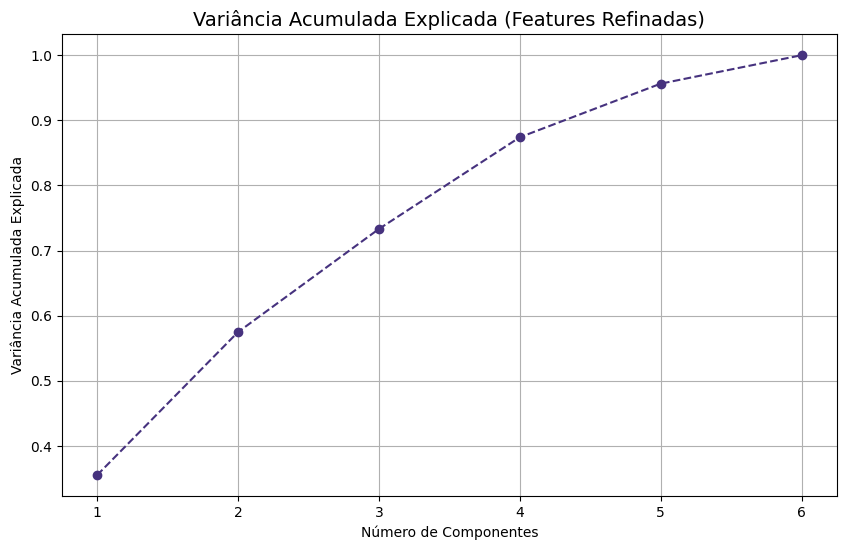

In [55]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Documentação:
# Aplicamos o PCA ao nosso novo conjunto de dados ('df_modelo_scaled') para
# analisar a variância explicada pelos componentes.
print("Executando a análise de PCA no novo conjunto de dados...")
pca_novo = PCA()
principal_components_novo = pca_novo.fit_transform(df_modelo_scaled)

# Calculamos a porcentagem de variância que cada componente explica
explained_variance_novo = pca_novo.explained_variance_ratio_

# Criamos um gráfico da variância acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_novo) + 1), np.cumsum(explained_variance_novo), marker='o', linestyle='--')
plt.title('Variância Acumulada Explicada (Features Refinadas)', fontsize=14)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada Explicada')
plt.grid(True)
plt.show()


Executando o Método do Cotovelo no novo conjunto de dados...


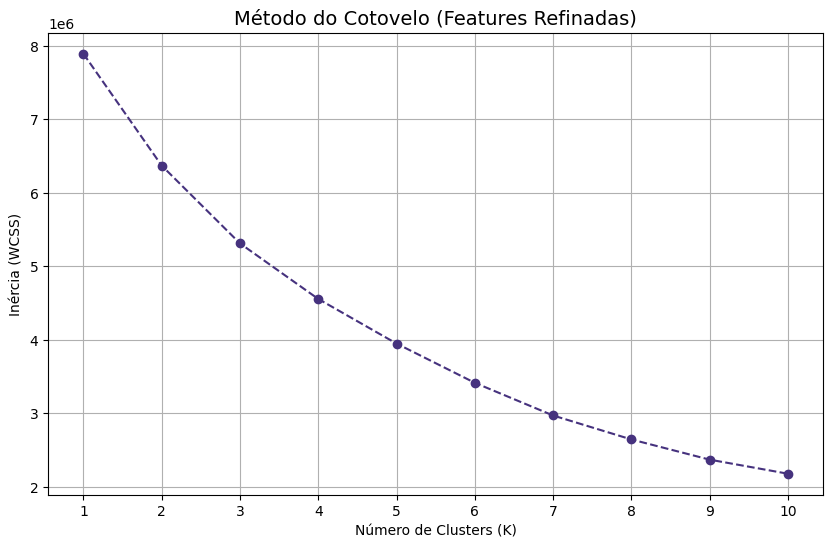

In [56]:
from sklearn.cluster import KMeans

# Documentação:
# Aplicamos o método do cotovelo para encontrar o número ideal de clusters (K).
# Usamos os dados já escalados e refinados ('df_modelo_scaled').
print("\nExecutando o Método do Cotovelo no novo conjunto de dados...")
wcss_novo = []
range_clusters = range(1, 11)

for i in range_clusters:
    kmeans_novo = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_novo.fit(df_modelo_scaled)
    wcss_novo.append(kmeans_novo.inertia_)

# Criamos o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, wcss_novo, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Features Refinadas)', fontsize=14)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

###PARTE ANTIGA ABAIXO

Garantindo a unificação completa do dataframe 'df_professores'...
Unificação verificada e completa.
--------------------------------------------------
Gerando a matriz de correlação completa...


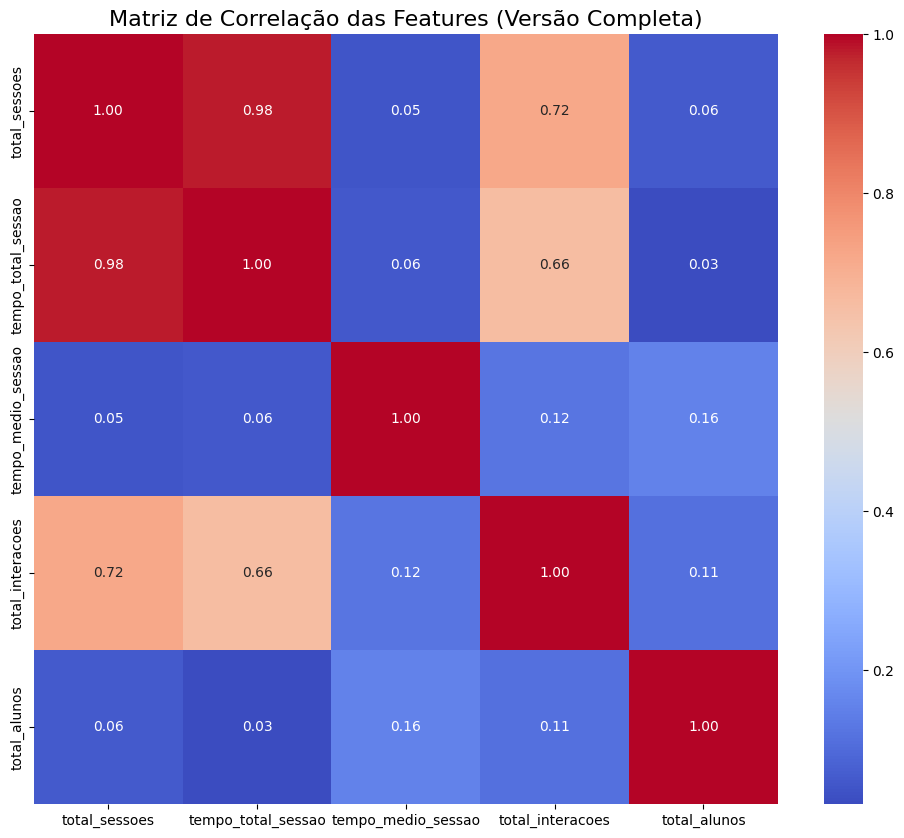

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- PASSO A: GARANTIR QUE A UNIFICAÇÃO ESTÁ COMPLETA ---
# Documentação: Recriamos o dataframe 'df_professores' para garantir
# que a junção com 'df_interaction_agg' (que contém as colunas 'evento_*') está incluída.

print("Garantindo a unificação completa do dataframe 'df_professores'...")

# Merge com os dados de sessão
df_professores = pd.merge(
    dim_teachers,
    df_entries_agg,
    on='unique_id',
    how='left'
)

# Merge com os dados de interação (ESSENCIAL PARA INCLUIR AS COLUNAS 'evento_*')
df_professores = pd.merge(
    df_professores,
    df_interaction_agg,
    on='unique_id',
    how='left'
)

# Preenchendo todos os valores nulos numéricos com 0
colunas_para_preencher = [
    'total_sessoes', 'tempo_total_sessao', 'tempo_medio_sessao', 'total_interacoes',
    'evento_create', 'evento_delete', 'evento_download', 'evento_share', 'evento_view'
]
colunas_existentes = [col for col in colunas_para_preencher if col in df_professores.columns]
for coluna in colunas_existentes:
    df_professores[coluna].fillna(0, inplace=True)

print("Unificação verificada e completa.")
print("-" * 50)


# --- PASSO B: GERAR O HEATMAP NOVAMENTE ---
# Documentação: Agora que 'df_professores' está garantidamente correto,
# geramos a matriz de correlação novamente.

print("Gerando a matriz de correlação completa...")

# Tratando 'total_alunos' e definindo a lista ampla de features
df_professores['total_alunos'].fillna(0, inplace=True)
features_ampliadas = [
    'total_sessoes', 'tempo_total_sessao', 'tempo_medio_sessao', 'total_interacoes', 'total_alunos',
    'evento_create', 'evento_delete', 'evento_download', 'evento_share', 'evento_view'
]
features_existentes_ampliadas = [col for col in features_ampliadas if col in df_professores.columns]
df_features_ampliadas = df_professores[features_existentes_ampliadas]

# Calculando e plotando a matriz de correlação
correlation_matrix = df_features_ampliadas.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Matriz de Correlação das Features (Versão Completa)", fontsize=16)
plt.show()

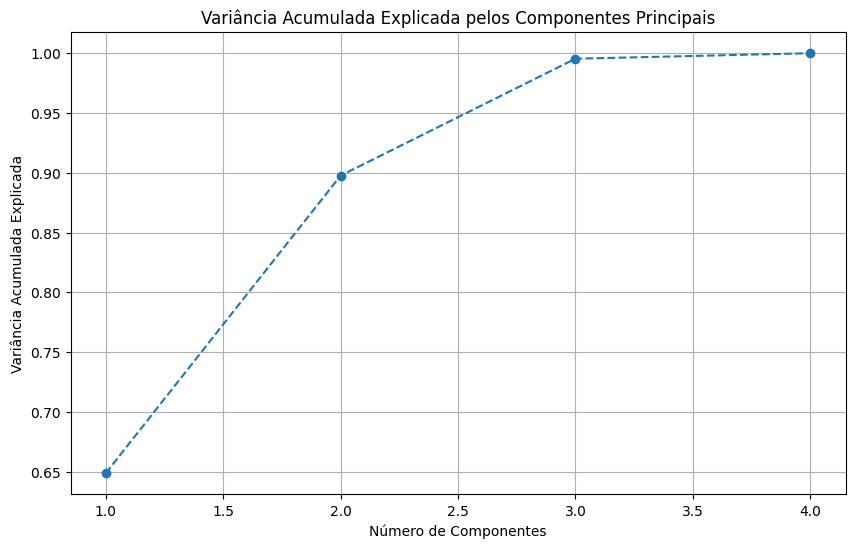

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Documentação:
# Instanciamos o PCA sem definir um número de componentes para que ele use todos os 9 possíveis.
# Isso nos permite analisar o quanto cada componente contribui para a explicação dos dados.
pca = PCA()
principal_components = pca.fit_transform(df_features_scaled)

# Calculamos a porcentagem de variância que cada componente explica
explained_variance = pca.explained_variance_ratio_

# Criamos um gráfico da variância acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Variância Acumulada Explicada pelos Componentes Principais')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada Explicada')
plt.grid(True)
plt.show()

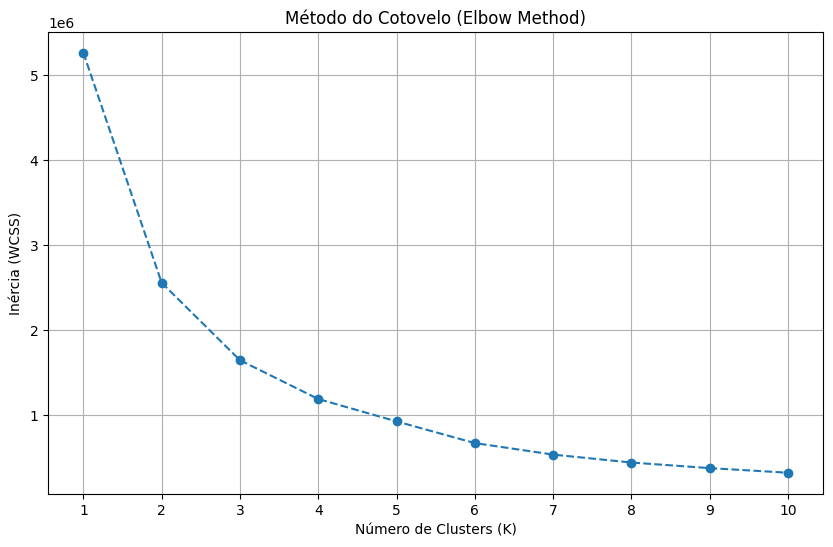

In [20]:
from sklearn.cluster import KMeans

# Documentação:
# Vamos testar o K-Means com um número de clusters de 1 a 10.
# Para cada número, armazenaremos o valor da inércia (WCSS - Within-Cluster Sum of Squares).
# Usaremos os dados já escalonados ('df_features_scaled') como entrada.
wcss = []
range_clusters = range(1, 11)

for i in range_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(df_features_scaled)
    wcss.append(kmeans.inertia_)

# Criamos o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [22]:
# --- PASSO FINAL (CORRIGIDO): RODAR OS MODELOS E ANALISAR OS CLUSTERS ---

# 1. Aplicar o PCA com o número de componentes que decidimos
# CORREÇÃO: Ajustado para 4, pois o dataframe de features tem 4 colunas.
pca = PCA(n_components=4)
# Usamos os dados escalonados como entrada
principal_components = pca.fit_transform(df_features_scaled)
print("PCA com 4 componentes aplicado com sucesso.")


# 2. Aplicar o K-Means com K=3
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
# Usamos os dados transformados pelo PCA como entrada para o K-Means
kmeans.fit(principal_components)
print("K-Means com K=3 aplicado com sucesso.")


# 3. Adicionar os rótulos dos clusters ao nosso dataframe original
# A variável 'kmeans.labels_' contém um array com o cluster atribuído a cada professor
df_professores['cluster'] = kmeans.labels_
print("Rótulos dos clusters adicionados ao dataframe 'df_professores'.")


# 4. Analisar os perfis de cada cluster
# Documentação:
# Agrupamos os professores por cluster e calculamos a média de suas características.
# Isso nos mostrará o que define cada grupo.
perfis_clusters = df_features.copy()
perfis_clusters['cluster'] = kmeans.labels_

# Calculamos a média de cada feature para cada cluster
analise_final = perfis_clusters.groupby('cluster').mean()

print("\n--- ANÁLISE FINAL: PERFIL MÉDIO DE CADA CLUSTER ---")
print(analise_final)

PCA com 4 componentes aplicado com sucesso.
K-Means com K=3 aplicado com sucesso.
Rótulos dos clusters adicionados ao dataframe 'df_professores'.

--- ANÁLISE FINAL: PERFIL MÉDIO DE CADA CLUSTER ---
         total_sessoes  tempo_total_sessao  tempo_medio_sessao  \
cluster                                                          
0             1.578073            1.572355            0.512337   
1         11215.000000       135503.826633           12.082374   
2             8.859488           74.617821           14.427246   

         total_interacoes  
cluster                    
0                1.686710  
1            10329.000000  
2               29.363699  


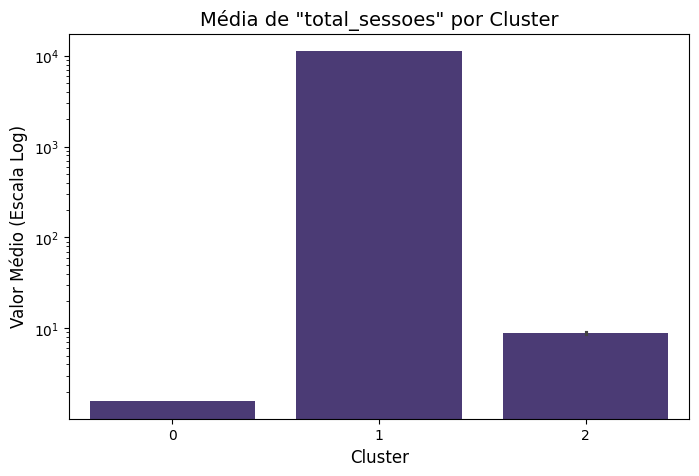

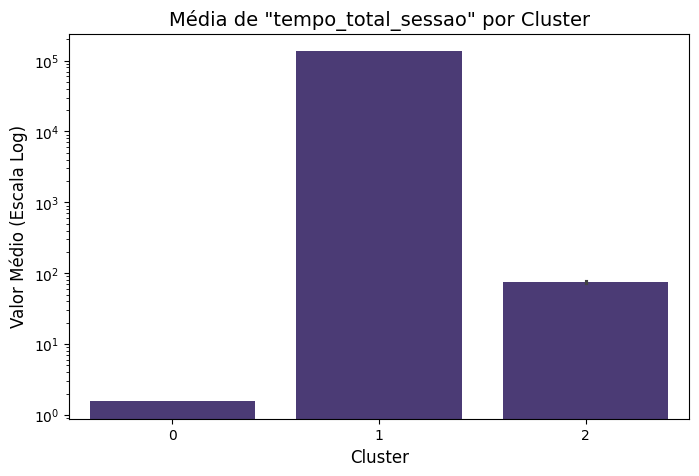

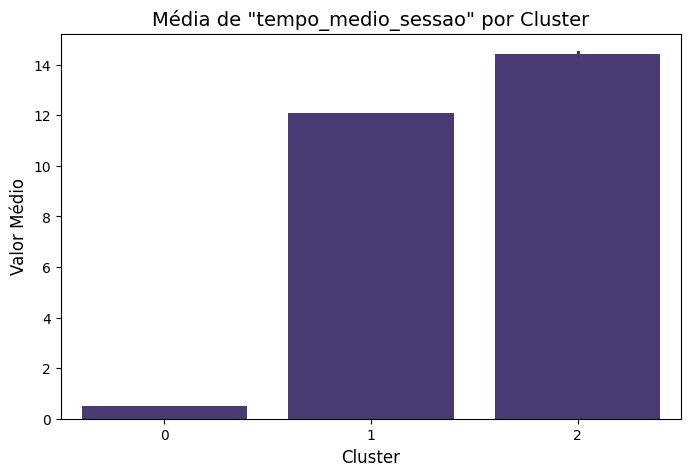

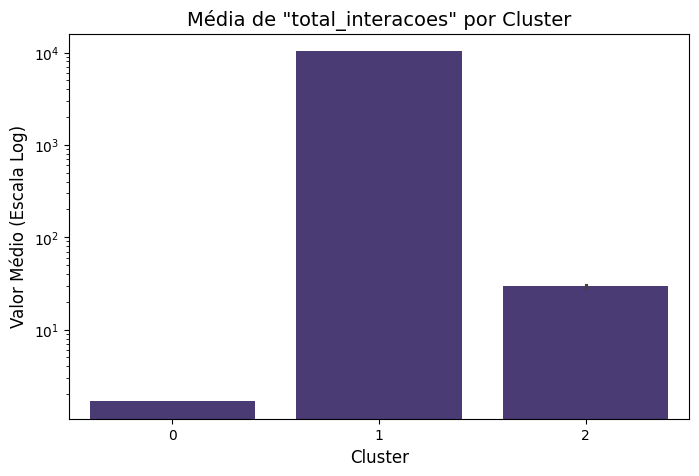

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Documentação:
# Iremos iterar sobre cada feature numérica que usamos no modelo para criar um gráfico de barras.
# O gráfico mostrará o valor médio da feature para cada um dos 3 clusters.

# Lista de features que queremos visualizar.
features_para_visualizar = [
    'total_sessoes',
    'tempo_total_sessao',
    'tempo_medio_sessao',
    'total_interacoes'
]

# Definindo uma paleta de cores para os clusters
sns.set_palette("viridis")

for feature in features_para_visualizar:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        x='cluster',
        y=feature,
        data=df_professores
    )
    ax.set_title(f'Média de "{feature}" por Cluster', fontsize=14)
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_ylabel("Valor Médio", fontsize=12)

    # Usar escala logarítmica para features com valores muito discrepantes
    if feature in ['total_sessoes', 'tempo_total_sessao', 'total_interacoes']:
        ax.set_yscale('log')
        ax.set_ylabel("Valor Médio (Escala Log)", fontsize=12)

    plt.show()

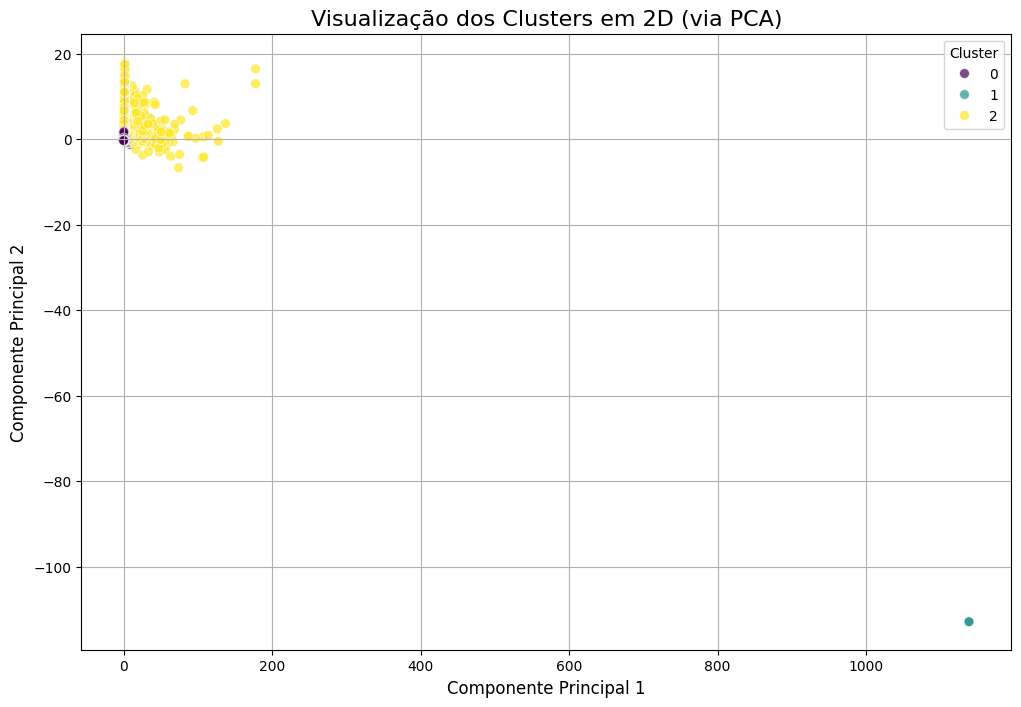

In [24]:
# Documentação:
# Criamos um gráfico de dispersão usando os dois primeiros componentes principais (PC1 e PC2).
# Cada ponto no gráfico é um professor.
# A cor de cada ponto é definida pelo cluster ao qual ele pertence.

# Criamos um DataFrame temporário para facilitar a plotagem com os resultados do PCA
df_pca_plot = pd.DataFrame(
    principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)
df_pca_plot['cluster'] = df_professores['cluster']

# Plotamos o gráfico de dispersão
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster',
    data=df_pca_plot,
    palette="viridis",
    alpha=0.7,  # Adicionamos um pouco de transparência
    s=50      # Aumentamos um pouco o tamanho dos pontos
)

ax.set_title("Visualização dos Clusters em 2D (via PCA)", fontsize=16)
ax.set_xlabel("Componente Principal 1", fontsize=12)
ax.set_ylabel("Componente Principal 2", fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Visualizando 1316093 professores dos clusters 0 e 2.


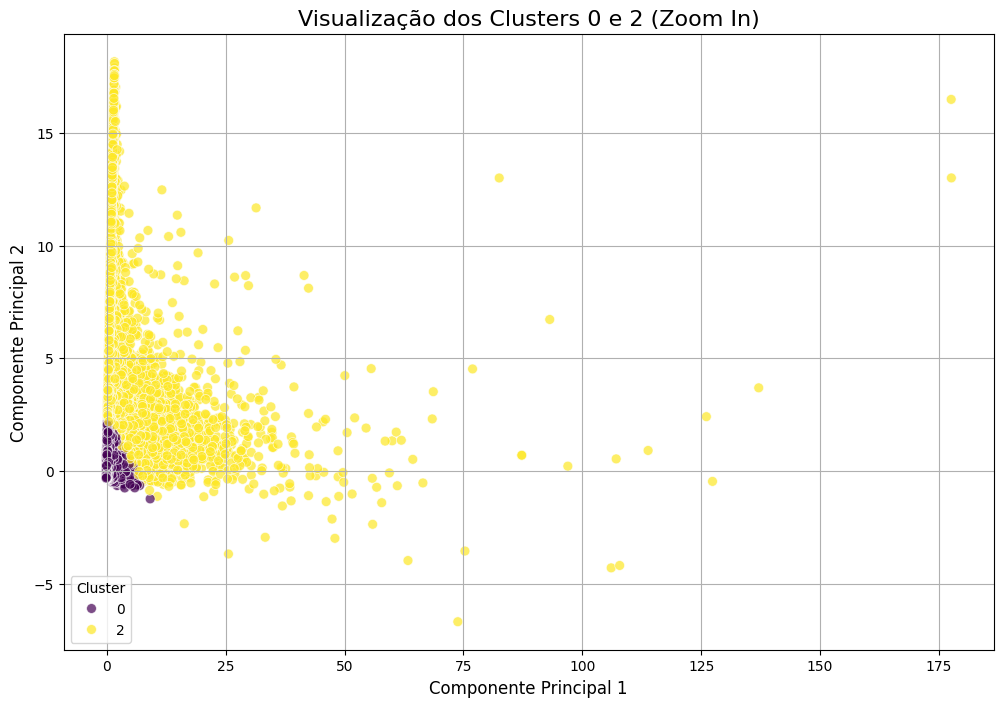

In [25]:
# Documentação:
# Para melhorar a visualização, vamos focar nos dois maiores grupos.
# Primeiro, criamos um novo dataframe filtrando apenas os professores dos clusters 0 e 2.
df_plot_zoomed = df_pca_plot[df_pca_plot['cluster'] != 1]

print(f"Visualizando {len(df_plot_zoomed)} professores dos clusters 0 e 2.")

# Agora, recriamos o gráfico de dispersão com esses dados filtrados.
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster',
    data=df_plot_zoomed,
    palette="viridis",
    alpha=0.7,
    s=50
)

ax.set_title("Visualização dos Clusters 0 e 2 (Zoom In)", fontsize=16)
ax.set_xlabel("Componente Principal 1", fontsize=12)
ax.set_ylabel("Componente Principal 2", fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

1. Fazer correlação das colunas (features para modelo de cluster);
2. Se tiver uma muito correlacionada, pega uma só;
3. Padronização;
4. Rodar cluster com o scaling